## Bayes error

- if we knew the distributions generating our data the Bayes Classifier would give the lowest possible generalization error
- refs [[bayes KNN](http://www.cs.cmu.edu/~epxing/Class/10701-10s/Lecture/lecture3.pdf)], [[no free lunch](http://www.santafe.edu/media/workingpapers/12-10-017.pdf)]

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.cm as cm
from tqdm import tqdm
import sys
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import multivariate_normal
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.n


In [2]:
def plot_2D_boundary(predict, mins, maxs, line_width=3, line_color="black", line_alpha=1, label=None):
    n = 200
    mins -= np.abs(mins)*.2
    maxs += np.abs(maxs)*.2
    d0 = np.linspace(mins[0], maxs[0],n)
    d1 = np.linspace(mins[1], maxs[1],n)
    gd0,gd1 = np.meshgrid(d0,d1)
    D = np.hstack((gd0.reshape(-1,1), gd1.reshape(-1,1)))
    p = (predict(D)*1.).reshape((n,n))
    plt.contour(gd0,gd1,p, levels=[-0.1,0.5], alpha=line_alpha, colors=line_color, linewidths=line_width)
    if label is not None:
        plt.plot([0,0],[0,0], lw=line_width, color=line_color, label=label)
    return np.sum(p==0)*1./n**2, np.sum(p==1)*1./n**2    

def plot_2Ddata_with_boundary(predict, X, y, line_width=3, line_alpha=1, line_color="black", dots_alpha=.5, label=None):
    colors = cm.hsv(np.linspace(0, .7, 2))
    mins,maxs = np.min(X,axis=0), np.max(X,axis=0)    
    p0, p1 = plot_2D_boundary(predict, mins, maxs, line_width, line_color, line_alpha, label )
    plt.scatter(X[y==0][:,0], X[y==0][:,1], color=colors[0], alpha=dots_alpha)
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color=colors[1], alpha=dots_alpha)
    return p0, p1

In [6]:
class Example_Bayes2DClassifier():
    
    def __init__ (self, mean0, cov0, mean1, cov1, w0=1, w1=1):
        self.rv0 = multivariate_normal(mean0, cov0)
        self.rv1 = multivariate_normal(mean1, cov1)
        self.w0  = w0
        self.w1  = w1

    def sample (self, n_samples=100):
        n = int(n_samples)
        n0 = int(n*1.*self.w0/(self.w0+self.w1))
        n1 = int(n) - n0
        X = np.vstack((self.rv0.rvs(n0), self.rv1.rvs(n1)))
        y = np.zeros(n)
        y[n0:] = 1
        
        return X,y
        
    def fit(self, X,y):
        pass
    
    def predict(self, X):
        p0 = self.rv0.pdf(X)
        p1 = self.rv1.pdf(X)
        return 1*(p1>p0)
    
    def score(self, X, y):
        return np.sum(self.predict(X)==y)*1./len(y)
    
    def analytic_score(self):
        """
        returns the analytic score on the knowledge of the probability distributions.
        the computation is a numeric approximation.
        """

        # first get limits for numeric computation. 
        # points all along the bounding box should have very low probability
        def get_boundingbox_probs(pdf, box_size):
            lp = np.linspace(-box_size,box_size,50)
            cp = np.ones(len(lp))*lp[0]
            bp = np.sum([pdf([x,y]) for x,y in zip(lp, cp)]  + \
                        [pdf([x,y]) for x,y in zip(lp, -cp)] + \
                        [pdf([y,x]) for x,y in zip(lp, cp)]  + \
                        [pdf([y,x]) for x,y in zip(lp, -cp)])
            return bp

        rngs = np.exp(np.arange(15))
        for rng in rngs:
            bp0 = get_boundingbox_probs(self.rv0.pdf, rng)
            bp1 = get_boundingbox_probs(self.rv1.pdf, rng)
            if bp0<1e-5 and bp1<1e-5:
                break

        if rng==rngs[-1]:
            print "warning: bounding box prob size",rng,"has prob",np.max([bp0, bp1])        
        
        
        # then, compute numerical approximation by building a grid
        mins, maxs = [-rng, -rng], [+rng, +rng]
        n = 100
        d0 = np.linspace(mins[0], maxs[0],n)
        d1 = np.linspace(mins[1], maxs[1],n)
        gd0,gd1 = np.meshgrid(d0,d1)
        D = np.hstack((gd0.reshape(-1,1), gd1.reshape(-1,1)))

        p0, p1 = self.rv0.pdf(D), self.rv1.pdf(D)

        # grid points where distrib 1 has greater probability than distrib 0
        gx = (p1-p0>0)*1.

        # true positive and true negative rates
        tnr = np.sum(p0*(1-gx))/np.sum(p0)
        tpr = np.sum(p1*gx)/np.sum(p1)
        return (self.w0*tnr+self.w1*tpr)/(self.w0+self.w1)  

def plot_estimator_border(bayes_classifier, estimators, n_samples=500):
    try:
        nns = [10,50,100]
        pbar = tqdm(total=len(estimators), ascii=False, file=sys.stdout, ncols=100)
        X,y = bayes_classifier.sample(n_samples)
        plt.figure(figsize=(15,3))
        for i,k in enumerate(sorted(estimators.keys())):
            estimator = estimators[k]
            pbar.update()
            plt.subplot(1,len(estimators),i+1)
            estimator.fit(X,y)
            plot_2Ddata_with_boundary(estimator.predict, X, y, line_width=2, dots_alpha=.3, label="estimator boundary")
            plot_2D_boundary(bayes_classifier.predict, np.min(X, axis=0), np.max(X, axis=0), 
                             line_width=4, line_alpha=.7, line_color="green", label="bayes boundary")
            plt.title(k+", estimator=%.3f"%estimator.score(X,y)+ "\nanalytic=%.3f"%bayes_classifier.analytic_score())
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        pbar.close()
    except BaseException as e:
        pbar.close()
        raise e

def sample_borders(mc, estimator, samples, n_reps):
    try:
        pbar = tqdm(total=len(samples)*n_reps, ascii=False, file=sys.stdout, ncols=100)
        plt.figure(figsize=(15,3))
        for i,n_samples in enumerate(samples):
            plt.subplot(1,len(samples),i+1)
            for ii in range(n_reps):
                pbar.update()
                X,y = mc.sample(n_samples)
                estimator.fit(X,y)
                if ii==0:
                    plot_2D_boundary(estimator.predict, np.min(X, axis=0), np.max(X, axis=0), 
                                     line_width=1, line_alpha=.5, label="estimator boundaries")
                else:
                    plot_2D_boundary(estimator.predict, np.min(X, axis=0), np.max(X, axis=0), 
                                     line_width=1, line_alpha=.5)                    
                plt.title("n samples="+str(n_samples))
            plot_2D_boundary(mc.predict, np.min(X, axis=0), np.max(X, axis=0), 
                             line_width=5, line_alpha=1., line_color="green", label="bayes boundary")
        pbar.close()
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    except BaseException as e:
        pbar.close()
        raise e


## Bayes classifier frontiers

Bayes classification frontier shown. Try values of $n$ such as 5, 10, 20, 100, 200, 500 and compare empirical error $\hat{\epsilon}$ with analytical Bayes error $\epsilon$

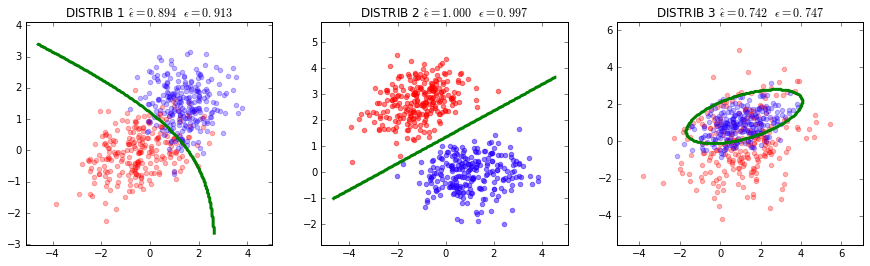

In [7]:
n=500

plt.figure(figsize=(15,4))
plt.subplot(131)
mc1 = Example_Bayes2DClassifier(mean0=[-0.5, 0], cov0=[[1.2, 0.3], [0.3, 0.5]],
                              mean1=[1.5,1.5], cov1=[[.7,0],[0,.5]])
X,y = mc1.sample(n)
plot_2Ddata_with_boundary(mc1.predict, X, y, line_width=3, line_color="green", dots_alpha=.3)
plt.title("DISTRIB 1 $\hat{\epsilon}=%.3f$"%mc1.score(X,y)+"  $\epsilon=%.3f$"%mc1.analytic_score())
plt.subplot(132)
mc2 = Example_Bayes2DClassifier(mean0=[-1.2, 2.7], cov0=[[1.2, 0.3], [0.3, 0.5]],
                               mean1=[ 1.2, 0], cov1=[[1.2,0],[0.3,.5]])
X,y = mc2.sample(n)
plot_2Ddata_with_boundary(mc2.predict, X, y, line_width=3, line_color="green",)
plt.title("DISTRIB 2 $\hat{\epsilon}=%.3f$"%mc2.score(X,y)+"  $\epsilon=%.3f$"%mc2.analytic_score())


plt.subplot(133)
mc3 = Example_Bayes2DClassifier(mean0=[1.0, 0], cov0=[[2, 0.3], [0.3, 2]],
                              mean1=[1.0,1.0], cov1=[[1.2, 0.3], [0.3, 0.5]])
X,y = mc3.sample(n)
plot_2Ddata_with_boundary(mc3.predict, X, y, line_width=3, line_color="green", dots_alpha=.3)
plt.title("DISTRIB 3 $\hat{\epsilon}=%.3f$"%mc3.score(X,y)+"  $\epsilon=%.3f$"%mc3.analytic_score())


## Exploring classification frontiers from KNeighbors

100%|█████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.43s/it]


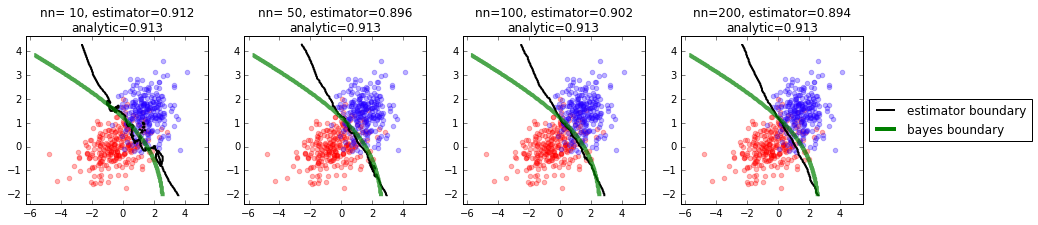

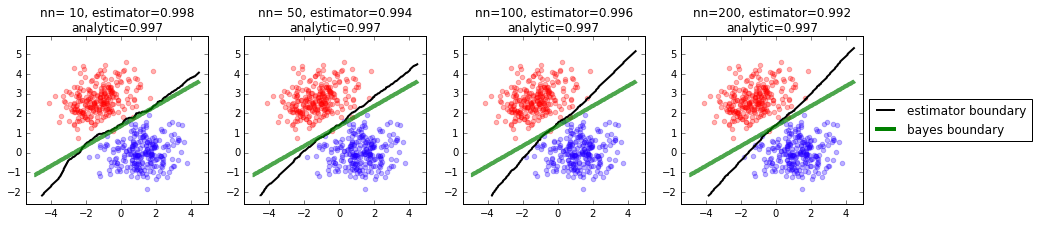

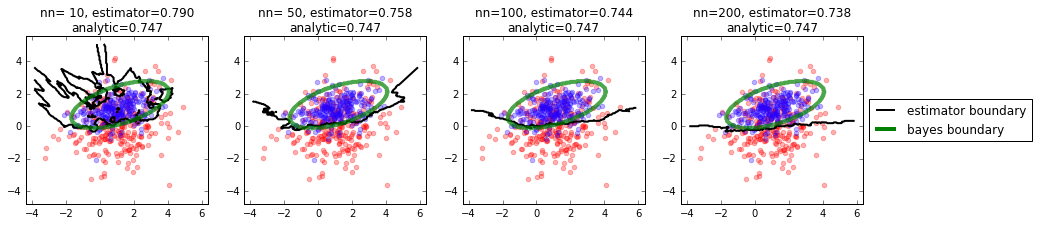

In [8]:
estimators = {"nn=%3d"%i: KNeighborsClassifier(i) for i in [10,50,100,200]}
for mc in [mc1, mc2, mc3]:
    plot_estimator_border(mc, estimators, n_samples=500)

100%|███████████████████████████████████████████████████████████████| 80/80 [00:11<00:00,  6.13it/s]


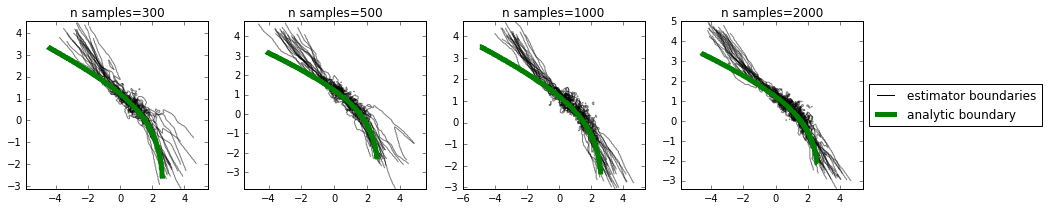

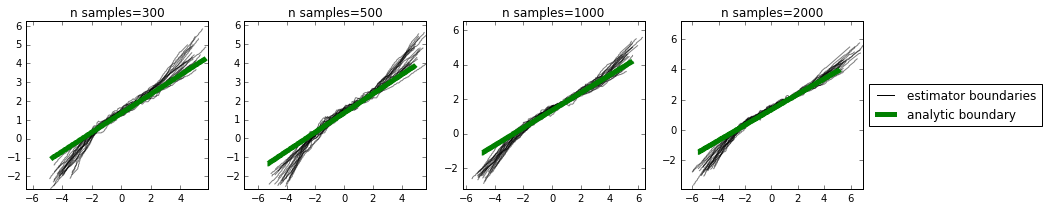

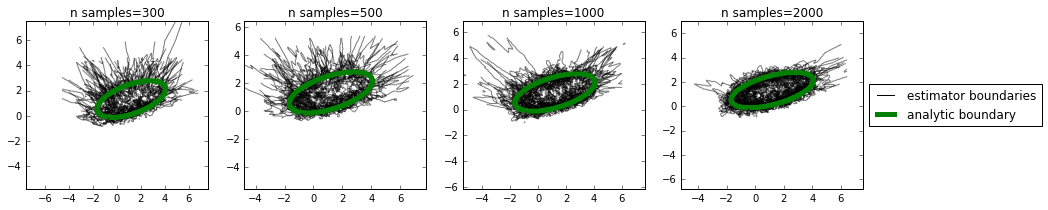

In [99]:
for mc in [mc1, mc2, mc3]:
    sample_borders(mc, KNeighborsClassifier(10), samples = [300,500,1000,2000], n_reps=20)

100%|███████████████████████████████████████████████████████████████| 80/80 [00:59<00:00,  1.27it/s]


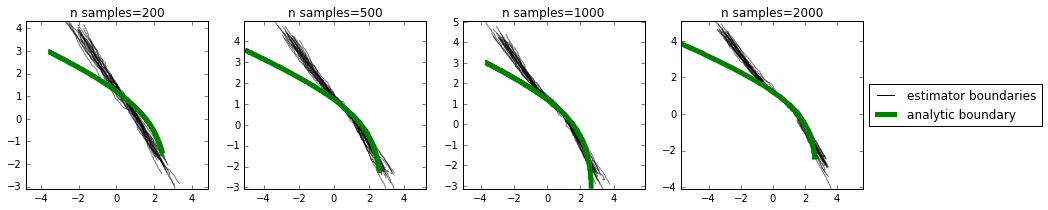

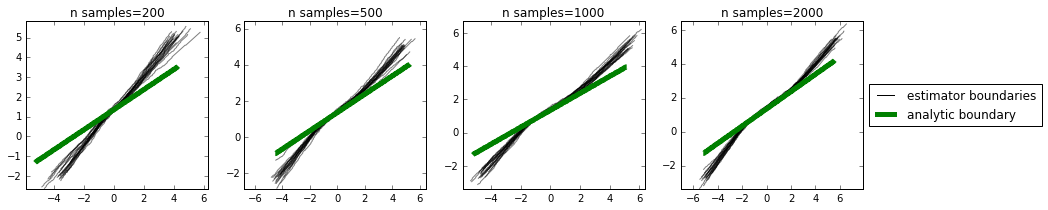

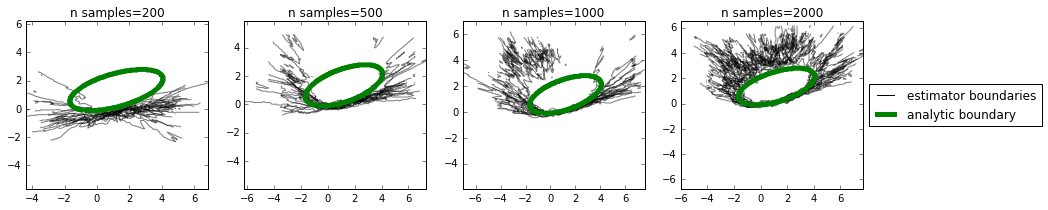

In [96]:
for mc in [mc1, mc2, mc3]:
    sample_borders(mc, KNeighborsClassifier(100), samples = [200,500,1000, 2000], n_reps=20)

100%|███████████████████████████████████████████████████████████████| 80/80 [02:06<00:00,  1.79s/it]


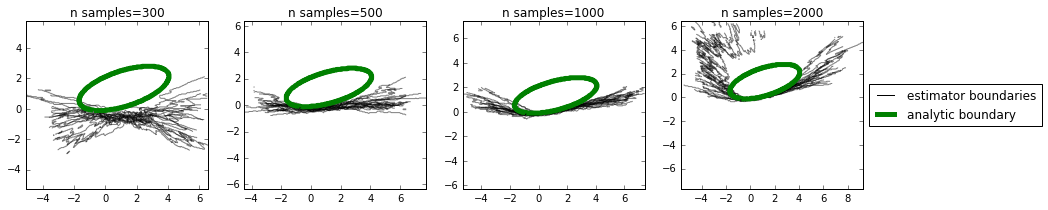

In [101]:
sample_borders(mc3, KNeighborsClassifier(200), samples = [300,500,1000,2000], n_reps=20)

## Exploring classification frontiers from SVMs

100%|█████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


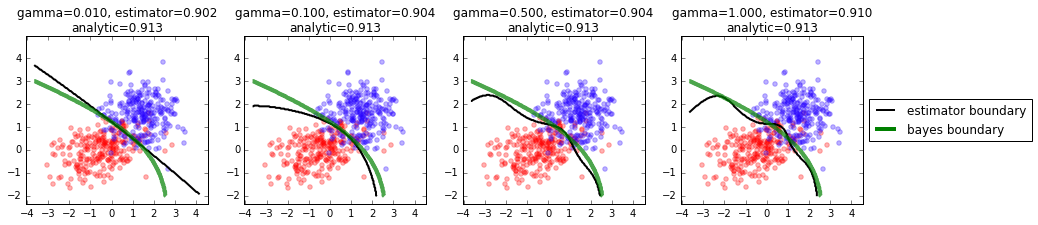

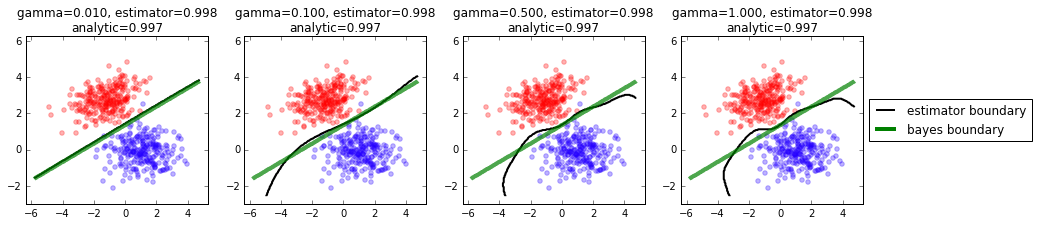

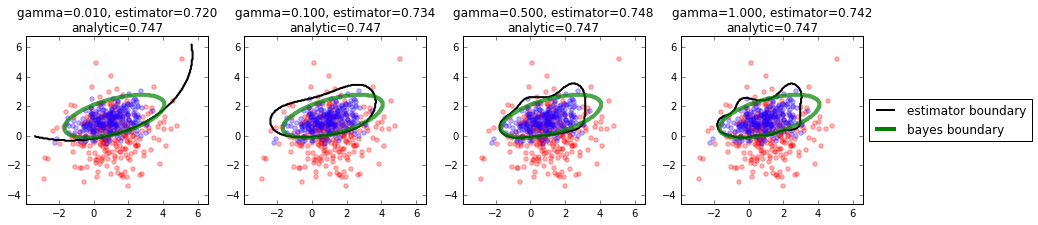

In [112]:
estimators = {"gamma=%.3f"%i: SVC(gamma=i) for i in [.01,.1,.5,1]}
for mc in [mc1, mc2, mc3]:
    plot_estimator_border(mc, estimators, n_samples=500)

100%|███████████████████████████████████████████████████████████████| 80/80 [00:42<00:00,  1.11s/it]


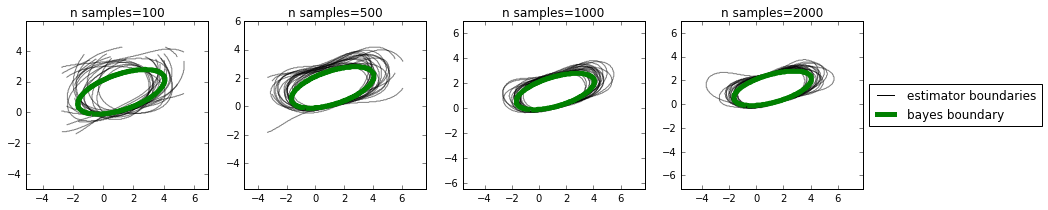

In [115]:
sample_borders(mc3, SVC(gamma=.1), samples = [100,500,1000,2000], n_reps=20)

## Exploring frontiers with:

- Logistic Regression
- Decission Tree
- Random Forests
- Multilayer Perceptron

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
estimators = {"logreg": LogisticRegression(), "rforest": RandomForestClassifier(), 
              "dtree": DecisionTreeClassifier(), "MLP": MLPClassifier()}
for mc in [mc1, mc2, mc3]:
    plot_estimator_border(mc, estimators, n_samples=500)

100%|███████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 31.01it/s]


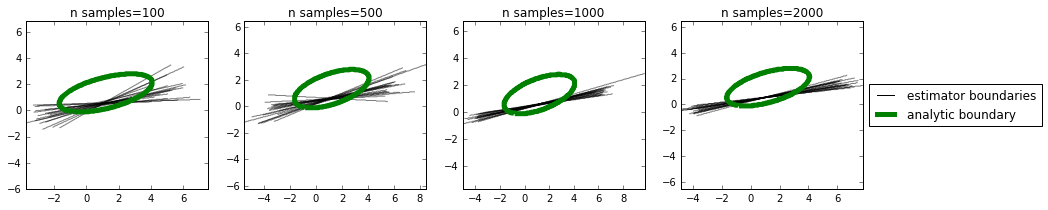

In [106]:
sample_borders(mc3, LogisticRegression(), samples = [100,500,1000, 2000], n_reps=20)

100%|███████████████████████████████████████████████████████████████| 80/80 [00:07<00:00,  9.07it/s]


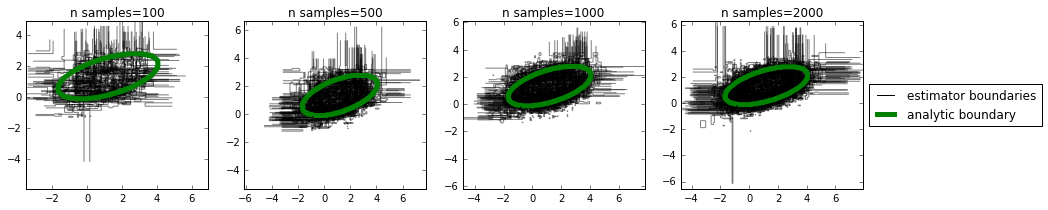

In [108]:
sample_borders(mc3, RandomForestClassifier(), samples = [100,500,1000, 2000], n_reps=20)

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


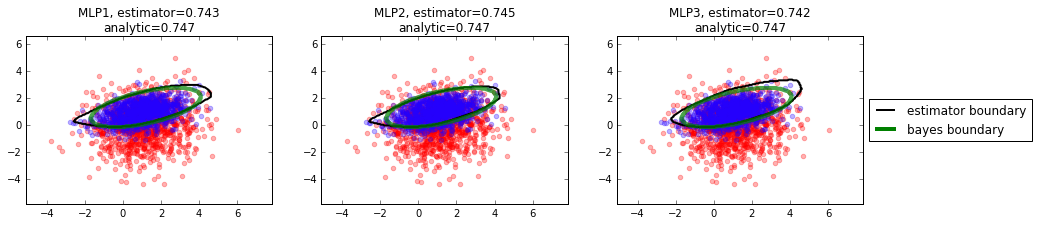

In [15]:
plot_estimator_border(mc3, {"MLP1": MLPClassifier(), "MLP2": MLPClassifier(), "MLP3": MLPClassifier()}, n_samples=2000)

100%|███████████████████████████████████████████████████████████████| 80/80 [01:32<00:00,  1.47s/it]


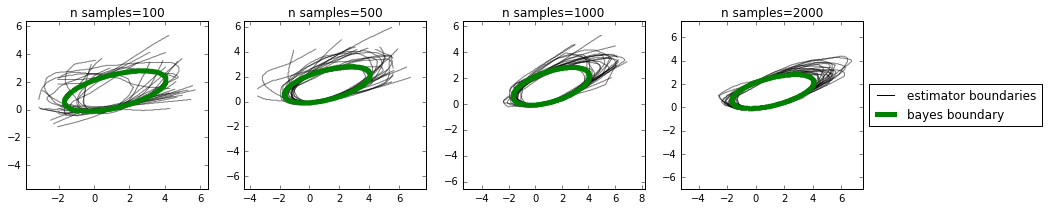

In [10]:
sample_borders(mc3, MLPClassifier(), samples = [100,500,1000, 2000], n_reps=20)